# PCB Defect Classification

A. Haidar, 
H. Amir, 
M. Chirag

In [1]:
# Establish Main Folder as Google Drive
"""
from google.colab import drive
drive.mount('/content/drive/')
"""

"\nfrom google.colab import drive\ndrive.mount('/content/drive/')\n"

In [4]:
! pip install opencv-python

  Using cached opencv_python-4.5.5.64-cp36-abi3-win_amd64.whl (35.4 MB)


In [50]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import matplotlib.image as img
from tensorflow.keras import layers, models
from gc import callbacks
import os
import cv2
import tempfile
import zipfile
import os

%matplotlib inline

In [6]:
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity 


In [24]:
class Data_Processor:
    def __init__(self, folder, img_size, des_size, des_box_size):
        self.folder = folder
        self.img_size = img_size
        self.des_size = des_size
        self.des_box_size = des_box_size
        self.num_train = 1000
        self.num_test = 500
        self.num_classes = 6
        self.X_train_loc, self.X_train_temp_loc, self.y_train_loc, \
            self.X_test_loc, self.X_test_temp_loc, self.y_test_loc = self.file_loc()
        self.X_train, self.X_train_temp, self.X_test, self.X_test_temp = self.img_reader()
        self.y_train, self.y_test = self.label_reader()

    def file_loc(self):
        # Reads text files
        with open (self.folder+"/trainval.txt", "r") as f1, open (self.folder+"/test.txt", "r") as f2:
            train_labels = f1.read()
            test_labels = f2.read()

        train_labels, test_labels = train_labels.split("\n"), test_labels.split("\n")
        Temp = np.array([train_labels[i].split(" ") for i in range(self.num_train)])
        X_train_loc_pre, y_train_loc = Temp[:,0], Temp[:,1]
        Temp = np.array([test_labels[i].split(" ") for i in range(self.num_test)])
        X_test_loc_pre, y_test_loc = Temp[:,0], Temp[:,1]

        X_train_loc = []
        X_test_loc = []
        X_train_temp_loc = []
        X_test_temp_loc = []
        for i in range(self.num_train):
            X_train_loc.append(X_train_loc_pre[i].replace(".jpg", "_test.jpg"))
            X_train_temp_loc.append(X_train_loc_pre[i].replace(".jpg", "_temp.jpg"))
        for i in range(self.num_test):
            X_test_loc.append(X_test_loc_pre[i].replace(".jpg", "_test.jpg"))
            X_test_temp_loc.append(X_test_loc_pre[i].replace(".jpg", "_temp.jpg"))

        X_train_loc = np.array(X_train_loc)
        X_train_temp_loc = np.array(X_train_temp_loc)
        X_test_loc = np.array(X_test_loc)
        X_test_temp_loc = np.array(X_test_temp_loc)
        return X_train_loc, X_train_temp_loc, y_train_loc, X_test_loc, X_test_temp_loc, y_test_loc

    def img_reader(self):
        # Read all images and convert to B&W
        X_train = np.zeros([self.num_train, self.des_size, self.des_size], dtype=np.float16)
        X_train_temp = np.zeros([self.num_train, self.des_size, self.des_size], dtype=np.float16)
        X_test = np.zeros([self.num_test, self.des_size, self.des_size], dtype=np.float16)
        X_test_temp = np.zeros([self.num_test, self.des_size, self.des_size], dtype=np.float16)

        for i in range(self.num_train):
            Train = img.imread(self.folder + "/" + self.X_train_loc[i])/255
            T_Temp = img.imread(self.folder + "/" + self.X_train_temp_loc[i])/255

            if len(Train.shape) == 2: #If black and white
                Train = cv2.resize(Train, (self.des_size, self.des_size))
                X_train[i] = Train
            else: #If RGB
                Train = cv2.resize(np.max(Train, axis=-1), (self.des_size, self.des_size))
                X_train[i] = Train

            if len(T_Temp.shape) == 2:
                T_Temp = cv2.resize(T_Temp, (self.des_size, self.des_size))
                X_train_temp[i] = T_Temp
            else:
                T_Temp = cv2.resize(np.max(T_Temp, axis=-1), (self.des_size, self.des_size))
                X_train_temp[i] = T_Temp

        for i in range(self.num_test):
            Test = img.imread(self.folder + "/" + self.X_test_loc[i])/255
            T_Temp = img.imread(self.folder + "/" + self.X_test_temp_loc[i])/255

            if len(Test.shape) == 2:
                Test = cv2.resize(Test, (self.des_size, self.des_size))
                X_test[i] = Test
            else:
                Test = cv2.resize(np.max(Test, axis=-1), (self.des_size, self.des_size))
                X_test[i] = np.max(Test, axis=-1)

            if len(T_Temp.shape) == 2:
                T_Temp = cv2.resize(T_Temp, (self.des_size, self.des_size))
                X_test_temp[i] = T_Temp
            else:
                T_Temp = cv2.resize(np.max(T_Temp, axis=-1), (self.des_size, self.des_size))
                X_test_temp[i] = T_Temp

        return X_train, X_train_temp, X_test, X_test_temp

    def label_reader(self):
        # Read all labels
        y_train = []
        y_test = []
        for i in range(self.num_train):
            with open(self.folder+"/"+self.y_train_loc[i], "r") as f1:
                Temp = f1.read().split("\n")
            Temp = list(filter(None,Temp))
            Temp = np.array([Temp[j].split(" ") for j in range(len(Temp))])
            x1, y1, x2, y2, cs = Temp[:,0], Temp[:,1], Temp[:,2], Temp[:,3], Temp[:,4]

            Temp = np.zeros((self.img_size, self.img_size, 1))
            for j in range(x1.shape[0]):
                Temp = cv2.rectangle(Temp, (int(x1[j]), int(y1[j])), (int(x2[j]), int(y2[j])), color = int(cs[j]), thickness = int(-1))
            Temp = cv2.resize(Temp, (self.des_box_size, self.des_box_size))
            y_train.append(Temp)
        y_train = np.array(y_train)
                            
        for i in range(self.num_test):
            with open(self.folder+"/"+self.y_test_loc[i], "r") as f1:
                Temp = f1.read().split("\n")
            Temp = list(filter(None,Temp))
            Temp = np.array([Temp[j].split(" ") for j in range(len(Temp))])
            x1, y1, x2, y2, cs = Temp[:,0], Temp[:,1], Temp[:,2], Temp[:,3], Temp[:,4]

            Temp = np.zeros((self.img_size, self.img_size, 1))
            for j in range(x1.shape[0]):
                Temp = cv2.rectangle(Temp, (int(x1[j]), int(y1[j])), (int(x2[j]), int(y2[j])), color = int(cs[j]), thickness = int(-1))
            Temp = cv2.resize(Temp,(self.des_box_size, self.des_box_size))
            y_test.append(Temp)
        y_test = np.array(y_test)
        return y_train, y_test

In [25]:
# Load Data
folder = "PCBData"
reader = Data_Processor(folder, 640, 128, 88)

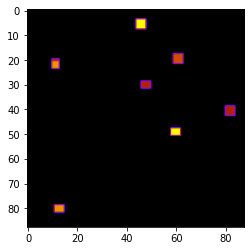

In [38]:
plt.imshow(np.reshape(reader.y_train[1],(reader.des_box_size,reader.des_box_size)),cmap='gnuplot')
plt.show()

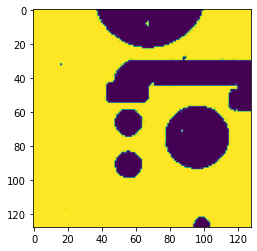

In [39]:
plt.imshow(reader.X_train[1])
plt.show()

In [40]:
dataset_train = tf.data.Dataset.from_tensor_slices((reader.X_train, reader.y_train))
dataset_test = tf.data.Dataset.from_tensor_slices((reader.X_test, reader.y_test))

BATCH_NUM = 128

dataset_train = dataset_train.shuffle(reader.num_train)
dataset_test = dataset_test.shuffle(reader.num_test)

dataset_train = dataset_train.batch(BATCH_NUM)
dataset_test = dataset_test.batch(BATCH_NUM)

# Build UNET

In [41]:
epochs = 4
end_step = np.ceil(1.0 * reader.num_train / BATCH_NUM).astype(np.int32) * epochs
print(end_step)

32


In [42]:
pruning_params = {
      'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.50,
                                                   final_sparsity=0.90,
                                                   begin_step=0,
                                                   end_step=end_step,
                                                   frequency=10)
}


In [51]:
## layer5 cnn bn he flip
inputs = keras.layers.Input((128,128,1))
# x = keras.layers.experimental.preprocessing.Resizing(128,128)(inputs)
x = keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical')(inputs)

x = sparsity.prune_low_magnitude(keras.layers.Conv2D(filters=64,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal()), **pruning_params)(x) #126 126 64
x = keras.layers.Activation('relu')(x)
#x = keras.layers.Dropout(0.2)(x)
x = sparsity.prune_low_magnitude(keras.layers.Conv2D(filters=64,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal()), **pruning_params)(x) #124 124 64
x = keras.layers.Activation('relu')(x)
#x = keras.layers.Dropout(0.2)(x)
x1 = tf.identity(x)
x1 = keras.layers.experimental.preprocessing.CenterCrop(92,92)(x1)

x = keras.layers.MaxPooling2D((2, 2), strides=2)(x) #62 62,64

x = sparsity.prune_low_magnitude(keras.layers.Conv2D(filters=128,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal()), **pruning_params)(x) #60 60 128
x = keras.layers.Activation('relu')(x)
#x = keras.layers.Dropout(0.2)(x)
x = sparsity.prune_low_magnitude(keras.layers.Conv2D(filters=128,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal()), **pruning_params)(x) #58 58 128
x = keras.layers.Activation('relu')(x)
#x = keras.layers.Dropout(0.2)(x)
x2 = tf.identity(x)
x2 = keras.layers.experimental.preprocessing.CenterCrop(50,50)(x2)

x = keras.layers.MaxPooling2D((2, 2), strides=2)(x) #29 29 128

x = sparsity.prune_low_magnitude(keras.layers.Conv2D(filters=256,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal()), **pruning_params)(x) #27 27 256
x = keras.layers.Activation('relu')(x)
#x = keras.layers.Dropout(0.2)(x)
x = sparsity.prune_low_magnitude(keras.layers.Conv2D(filters=256,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal()), **pruning_params)(x) #25 25 256
x = keras.layers.Activation('relu')(x)
#x = keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=2, strides=(2, 2),kernel_initializer=tf.keras.initializers.HeNormal())(x) # 50 50 128

x = keras.layers.Concatenate()([x,x2]) #50 50 256
x = sparsity.prune_low_magnitude(keras.layers.Conv2D(filters=128,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal()), **pruning_params)(x) #48 48 128
x = keras.layers.Activation('relu')(x)
#x = keras.layers.Dropout(0.2)(x)
x = sparsity.prune_low_magnitude(keras.layers.Conv2D(filters=128,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal()), **pruning_params)(x) #46 46 128
x = keras.layers.Activation('relu')(x)
#x = keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=2, strides=(2, 2),kernel_initializer=tf.keras.initializers.HeNormal())(x) # 92 92 64

x = keras.layers.Concatenate()([x,x1]) #92,92 128
x = sparsity.prune_low_magnitude(keras.layers.Conv2D(filters=64,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal()), **pruning_params)(x) #90 90 64
x = keras.layers.Activation('relu')(x)
#x = keras.layers.Dropout(0.2)(x)
x = sparsity.prune_low_magnitude(keras.layers.Conv2D(filters=64,kernel_size=3,kernel_initializer=tf.keras.initializers.HeNormal()), **pruning_params)(x) #88 88 64
x = keras.layers.Activation('relu')(x)
#x = keras.layers.Dropout(0.2)(x)

outputs = keras.layers.Conv2D(filters=7,kernel_size=1,kernel_initializer=tf.keras.initializers.HeNormal())(x) #88 88 7

C:\Users\chira\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_wrapper.py:218: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
C:\Users\chira\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_wrapper.py:225: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
C:\Users\chira\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_wrapper.py:238: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=False)


In [44]:
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 random_flip (RandomFlip)       (None, 128, 128, 1)  0           ['input_1[0][0]']                
                                                                                                  
 prune_low_magnitude_conv2d (Pr  (None, 126, 126, 64  1218       ['random_flip[0][0]']            
 uneLowMagnitude)               )                                                                 
                                                                                              

In [52]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [53]:
import tempfile
from keras.callbacks import ModelCheckpoint

savepath='Checkpoints/5_3_700'
checkpoint = ModelCheckpoint(savepath,monitor='val_loss',mode='min',save_best_only=True,verbose=1)

logdir = tempfile.mkdtemp()
callbacks = [
    sparsity.UpdatePruningStep(),
    sparsity.PruningSummaries(log_dir=logdir, profile_batch=0),
    checkpoint
]

In [59]:
# checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_pcb_defect_detection.h5', verbose=2, save_best_only=True) 
# callback = [
#     tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
#     tf.keras.callbacks.TensorBoard(log_dir='logs')]

In [64]:
history = model.fit(reader.X_train, reader.y_train, epochs=700, batch_size=128, callbacks=callbacks, validation_data=(reader.X_test, reader.y_test), verbose=1)
# history = model.fit(reader.X_train, reader.y_train, epochs=10, validation_data=(reader.X_test, reader.y_test), verbose=2)

Epoch 1/700
8/8 [==============================] - 111s 14s/step - loss: 0.2664 - accuracy: 0.9733 - val_loss: 0.1680 - val_accuracy: 0.9763
Epoch 2/700
8/8 [==============================] - 101s 13s/step - loss: 0.2319 - accuracy: 0.9733 - val_loss: 0.2133 - val_accuracy: 0.9763
Epoch 3/700
8/8 [==============================] - 101s 13s/step - loss: 0.1959 - accuracy: 0.9733 - val_loss: 0.1761 - val_accuracy: 0.9763


In [65]:
score = model.evaluate(reader.X_test, reader.y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])



Test loss: 0.17609785497188568
Test accuracy: 0.976331889629364


In [66]:
# Strip the pruning wrappers from the pruned model before export for serving

final_pruned_model = sparsity.strip_pruning(pruned_model)
final_pruned_model.summary()

NameError: name 'pruned_model' is not defined

Results: 

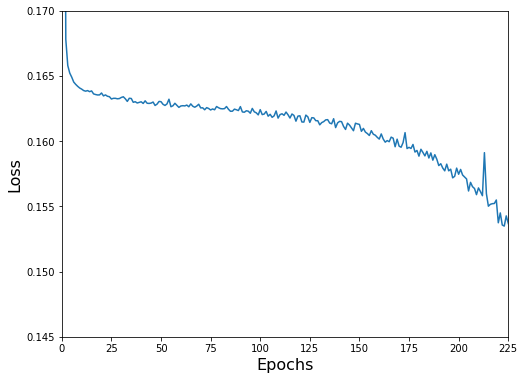

In [35]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'])
plt.ylim(0.145, 0.17)
plt.xlim(0, 225)
plt.xlabel("Epochs", size = 16)
plt.ylabel("Loss", size = 16)
plt.savefig('Loss.pdf', dpi=720, bbox_inches='tight')
plt.savefig('Loss.PNG', dpi=720, bbox_inches='tight')

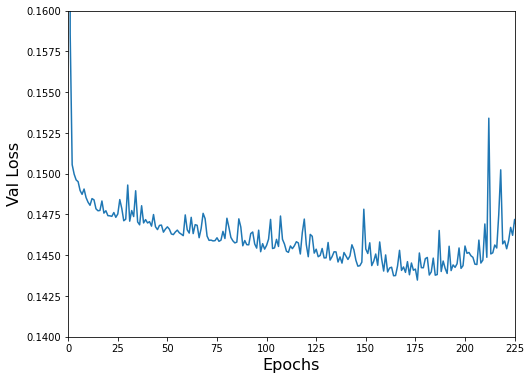

In [36]:
plt.figure(figsize=(8,6))
plt.plot(history.history['val_loss'])
plt.ylim(0.14, 0.16)
plt.xlim(0, 225)
plt.xlabel("Epochs", size = 16)
plt.ylabel("Val Loss", size = 16)
plt.savefig('ValLoss.pdf', dpi=720, bbox_inches='tight')
plt.savefig('ValLoss.PNG', dpi=720, bbox_inches='tight')

In [30]:
print(min(history.history["val_loss"]))
print(min(history.history["loss"]))

0.1434776932001114
0.0529971681535244


Plot Predict


In [1]:
out = model.predict(tf.reshape(reader.X_train[1],(-1,128,128,1)))
out2 = np.argmax(out,axis=3)
plt.imshow(out2[0],cmap='gnuplot')

NameError: name 'model' is not defined

In [38]:
# Save both Pruned and UNpruned versions 

''
_, pruned_model_file = tempfile.mkstemp('.h5')
print('Saving pruned model to: ', pruned_model_file)

# No need to save the optimizer with the graph for serving.
tf.keras.models.save_model(final_pruned_model, pruned_model_file, include_optimizer=False)   # Saved to: C:\Users\halsali\AppData\Local\Temp\tmpxudrrqjj.h5

''

Saving pruned model to:  C:\Users\halsali\AppData\Local\Temp\tmpwair0rmw.h5


NameError: name 'final_pruned_model' is not defined

Compare the size of the unpruned vs. pruned model after compression

In [37]:
# Compare the size of the unpruned vs. pruned model after compression

""

# _, zip1 = tempfile.mkstemp('.zip') 
# with zipfile.ZipFile(zip1, 'w', compression=zipfile.ZIP_DEFLATED) as f:
#   f.write(keras_file)
# print("Size of the unpruned model before compression: %.2f Mb" % 
#       (os.path.getsize(keras_file) / float(2**20)))
# print("Size of the unpruned model after compression: %.2f Mb" % 
#       (os.path.getsize(zip1) / float(2**20)))

_, zip2 = tempfile.mkstemp('.zip') 
with zipfile.ZipFile(zip2, 'w', compression=zipfile.ZIP_DEFLATED) as f:
  f.write(pruned_model_file)
print("Size of the unpruned model before compression: %.2f Mb" % 
      (os.path.getsize(pruned_model_file) / float(2**20)))
print("Size of the pruned model after compression: %.2f Mb" % 
      (os.path.getsize(zip2) / float(2**20)))

""

NameError: name 'pruned_model_file' is not defined

In [40]:
import shelve

In [45]:
import pickle

def backup(fileName):
    pickle.dump(globals(), open(fileName,'w'), pickle.HIGHEST_PROTOCOL)

def restore(fileName):
    globals().update(pickle.load(open(fileName,"rb"))) 

In [53]:
with open("losses", "wb") as f:
    pickle.dump(history.history["loss"], f)
    pickle.dump(history.history["loss"], f)


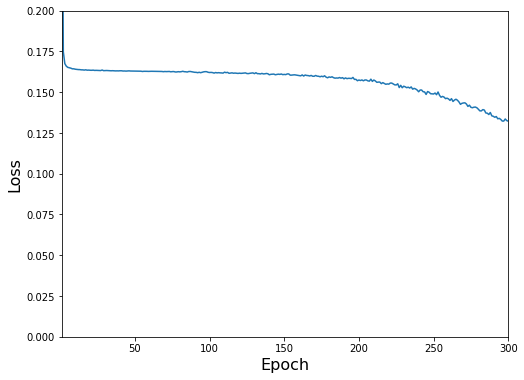

In [71]:
plt.figure(figsize=(8,6))
plt.plot(history.history["loss"])
plt.xlabel("Epoch", size = 16)
plt.ylabel("Loss", size = 16)
plt.ylim([0, 0.2])
plt.xlim([1,300])
plt.savefig('Loss.pdf', dpi=720, bbox_inches='tight')
plt.savefig('Loss.PNG', dpi=720, bbox_inches='tight')

(1.0, 300.0)

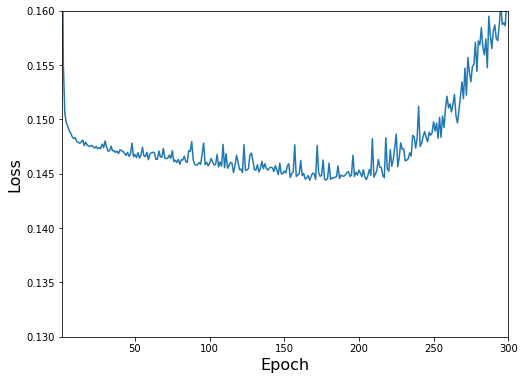

In [70]:
plt.figure(figsize=(8,6))
plt.plot(history.history["val_loss"])
plt.xlabel("Epoch", size = 16)
plt.ylabel("Loss", size = 16)
plt.ylim([0.13, 0.16])
plt.xlim([1,300])
#plt.savefig('Loss.pdf', dpi=300, bbox_inches='tight')

In [75]:
pred = model.predict(tf.reshape(reader.X_train[456],(-1,128,128,1)))
pred = np.argmax(pred,axis=3)[0]

In [98]:
imge = reader.X_train[456]

In [102]:
imge = cv2.resize(imge, (88,88))

error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src data type = 23 is not supported
>  - Expected Ptr<cv::UMat> for argument 'src'


In [103]:
pred2 = cv2.resize(pred, (128,128))

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:3930: error: (-215:Assertion failed) func != 0 in function 'cv::hal::resize'


In [83]:
type(img_arr_resized)

numpy.ndarray

In [76]:
from PIL import Image

In [ ]:


new_pred = np.zeros((reader.des_box_size, reader.des_box_size, 3),dtype=np.uint8)
new_pred[pred==0] = img_arr_resized[pred==0]
new_pred[pred==1] = [255,228,0] #open
new_pred[pred==2] = [1,0,255] #short
new_pred[pred==3] = [29,219,22] #mousebite
new_pred[pred==4] = [255,0,0] #spur
new_pred[pred==5] = [103,0,0] #copper
new_pred[pred==6] = [255,0,127] #pin-hole
blend_img1=Image.fromarray(img_arr_resized)
blend_img2=Image.fromarray(new_pred)
blend_img=Image.blend(blend_img1,blend_img2,0.5)